In [1]:
import numpy as np
from PIL import Image
import glob as gl
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset
from torchvision import models, transforms
from torch import nn, optim

In [2]:

print(torch.cuda.is_available())      # should be True
print(torch.cuda.get_device_name(0))  # should print RTX 4080
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # should print cuda


True
NVIDIA GeForce RTX 4080 Laptop GPU
cuda


In [47]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [48]:
! chmod 600 ~/.kaggle/kaggle.json

'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [49]:
! kaggle datasets download prashant268/chest-xray-covid19-pneumonia

^C


Dataset URL: https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia
License(s): unknown
chest-xray-covid19-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip chest-xray-covid19-pneumonia.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip chest-xray-pneumonia.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
image_size = 224 # For ResNet-50

In [ ]:
class XRayDataset(Dataset):
    def __init__(self, path_glob, label, transform=None):
        self.image_paths = gl.glob(path_glob)
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")  # ensure 3-channel
        if self.transform:
            img = self.transform(img)
        return img, self.label
    

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    # You can add Normalize if needed later
])

# def build_dataset(path):
#   images = gl.glob(path)
#   dataset = []
#   for image in images:

#     img = transforms.Resize((image_size, image_size))(Image.open(image))
#     img = transforms.Grayscale(3)(Image.open(image))
#     img = transforms.RandomRotation(10)(img)
#     img = transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2))(img)
#     img = transforms.ToTensor()(img)
#     img = transforms.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225])(img)
#     dataset.append(img)
#   return dataset

In [39]:
DATASET_1_TRAIN_PATH_COVID='Data/train/COVID19/*'
DATASET_1_TRAIN_PATH_NORMAL='Data/train/NORMAL/*'
DATASET_1_TRAIN_PATH_PNEUMONIA='Data/train/PNEUMONIA/*'
DATASET_2_TRAIN_PATH_NORMAL='chest_xray/train/NORMAL/*'
DATASET_2_TRAIN_PATH_PNEUMONIA='chest_xray/train/PNEUMONIA/*'
DATASET_1_TEST_PATH_COVID='Data/test/COVID19/*'
DATASET_1_TEST_PATH_NORMAL='Data/test/NORMAL/*'
DATASET_1_TEST_PATH_PNEUMONIA='Data/test/PNEUMONIA/*'
DATASET_2_TEST_PATH_NORMAL='chest_xray/test/NORMAL/*'
DATASET_2_TEST_PATH_PNEUMONIA='chest_xray/test/PNEUMONIA/*'
DATASET_2_VAL_PATH_NORMAL='chest_xray/val/NORMAL/*'
DATASET_2_VAL_PATH_PNEUMONIA='chest_xray/val/PNEUMONIA/*'

In [40]:

Classes = {
    'NORMAL': 0,
    'COVID19': 1,
    'PNEUMONIA': 2
}

In [74]:
# Latest using only dataset 1 with pneumonia , covid and normal
covid_train = XRayDataset(DATASET_1_TRAIN_PATH_COVID, 1, transform)
normal_train = XRayDataset(DATASET_1_TRAIN_PATH_NORMAL, 0, transform)
pneumonia_train = XRayDataset(DATASET_1_TRAIN_PATH_PNEUMONIA, 2, transform)

covid_test = XRayDataset(DATASET_1_TEST_PATH_COVID, 1, transform)
normal_test = XRayDataset(DATASET_1_TEST_PATH_NORMAL, 0, transform)
pneumonia_test = XRayDataset(DATASET_1_TEST_PATH_PNEUMONIA, 2, transform)

train_dataset = ConcatDataset([covid_train, normal_train, pneumonia_train])
test_dataset = ConcatDataset([covid_test, normal_test, pneumonia_test])


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)


# # LAtest but not giving good accuracy (45%)
# covid_train = XRayDataset(DATASET_1_TRAIN_PATH_COVID, 1, transform)
# normal_train_1 = XRayDataset(DATASET_1_TRAIN_PATH_NORMAL, 0, transform)
# pneumonia_train_1 = XRayDataset(DATASET_1_TRAIN_PATH_PNEUMONIA, 2, transform)

# # Dataset 2
# normal_train_2 = XRayDataset(DATASET_2_TRAIN_PATH_NORMAL, 0, transform)
# pneumonia_train_2 = XRayDataset(DATASET_2_TRAIN_PATH_PNEUMONIA, 2, transform)

# # Bin all normals together
# normal_train = ConcatDataset([normal_train_1, normal_train_2])

# # Bin all pneumonias together
# pneumonia_train = ConcatDataset([pneumonia_train_1, pneumonia_train_2])

# train_dataset = ConcatDataset([covid_train, normal_train, pneumonia_train])


# covid_test = XRayDataset(DATASET_1_TEST_PATH_COVID, 1, transform)
# normal_test_1 = XRayDataset(DATASET_1_TEST_PATH_NORMAL, 0, transform)
# pneumonia_test_1 = XRayDataset(DATASET_1_TEST_PATH_PNEUMONIA, 2, transform)

# normal_test_2 = XRayDataset(DATASET_2_TEST_PATH_NORMAL, 0, transform)
# pneumonia_test_2 = XRayDataset(DATASET_2_TEST_PATH_PNEUMONIA, 2, transform)

# normal_test = ConcatDataset([normal_test_1, normal_test_2])
# pneumonia_test = ConcatDataset([pneumonia_test_1, pneumonia_test_2])

# test_dataset = ConcatDataset([covid_test, normal_test, pneumonia_test])


# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)



#old one
# dataset_1_train_1 = build_dataset(DATASET_1_TRAIN_PATH_COVID)
# dataset_1_train_2 = build_dataset(DATASET_1_TRAIN_PATH_NORMAL)
# dataset_1_train_3 = build_dataset(DATASET_1_TRAIN_PATH_PNEUMONIA)
# dataset_2_train_1 = build_dataset(DATASET_2_TRAIN_PATH_NORMAL)
# dataset_2_train_2 = build_dataset(DATASET_2_TRAIN_PATH_PNEUMONIA)
# dataset_1_test_1 = build_dataset(DATASET_1_TEST_PATH_COVID)
# dataset_1_test_2 = build_dataset(DATASET_1_TEST_PATH_NORMAL)
# dataset_1_test_3 = build_dataset(DATASET_1_TEST_PATH_PNEUMONIA)
# dataset_2_test_1 = build_dataset(DATASET_2_TEST_PATH_NORMAL)
# dataset_2_test_2 = build_dataset(DATASET_2_TEST_PATH_PNEUMONIA)
# dataset_2_val_1 = build_dataset(DATASET_2_VAL_PATH_NORMAL)
# dataset_2_val_2 = build_dataset(DATASET_2_VAL_PATH_PNEUMONIA)

In [75]:
covid_x_train = covid_train
print(len(covid_x_train))

460


In [43]:
covid_y_train = [Classes['COVID19'] for i in range(len(covid_x_train))]
#print(len(covid_y_train))

In [76]:
covid_x_test = covid_test
print(len(covid_x_test))

116


In [77]:
covid_y_test = [Classes['COVID19'] for i in range(len(covid_x_test))]

In [78]:
normal_x_train = normal_train
print(len(normal_x_train))

1266


In [79]:
normal_y_train = [Classes['NORMAL'] for i in range(len(normal_x_train))]

In [80]:
normal_x_test = normal_test
print(len(normal_x_test))

317


In [81]:
normal_y_test = [Classes['NORMAL'] for i in range(len(normal_x_test))]

In [82]:
pneumonia_x_train = pneumonia_train
print(len(pneumonia_x_train))

3418


In [83]:
pneumonia_y_train = [Classes['PNEUMONIA'] for i in range(len(pneumonia_x_train))]

In [84]:
pneumonia_x_test = pneumonia_test
print(len(pneumonia_x_test))

855


In [85]:
pneumonia_y_test = [Classes['PNEUMONIA'] for i in range(len(pneumonia_x_test))]

In [86]:
x_train = covid_x_train + normal_x_train + pneumonia_x_train
x_test = covid_x_test + normal_x_test + pneumonia_x_test

In [87]:
y_train = covid_y_train + normal_y_train + pneumonia_y_train
y_test = covid_y_test + normal_y_test + pneumonia_y_test

In [88]:
print(type(x_train[0]))

<class 'tuple'>


In [89]:
len(x_train)

5144

In [90]:
pretrained_model = models.resnet50(weights='DEFAULT')
num_classes = 3

In [91]:
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

# Freeze the parameters of the pre-trained layers
for param in pretrained_model.parameters():
    param.requires_grad = False

# Unfreeze final classifier
for param in pretrained_model.fc.parameters():
    param.requires_grad = True

# Gradually unfreeze last few layers
for i in range(3):
    for param in getattr(pretrained_model, f'layer{4-i}').parameters():
        param.requires_grad = True

In [92]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

pretrained_model = pretrained_model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [95]:
epochs = 5
print(device)

cuda


In [96]:
from collections import Counter

all_labels = []
for _, label in train_dataset:
    all_labels.append(label)

print("Train class distribution:", Counter(all_labels))

Train class distribution: Counter({2: 3418, 0: 1266, 1: 460})


Epoch 1/5
Epoch [1/5] Train Loss: 0.0044  Validation Loss: 0.0021, Validation Accuracy: 95.03%
Epoch 2/5
Epoch [2/5] Train Loss: 0.0010  Validation Loss: 0.0019, Validation Accuracy: 95.81%
Epoch 3/5
Epoch [3/5] Train Loss: 0.0003  Validation Loss: 0.0021, Validation Accuracy: 96.04%
Epoch 4/5
Epoch [4/5] Train Loss: 0.0002  Validation Loss: 0.0018, Validation Accuracy: 96.97%
Epoch 5/5
Epoch [5/5] Train Loss: 0.0001  Validation Loss: 0.0020, Validation Accuracy: 96.43%
Finished Training


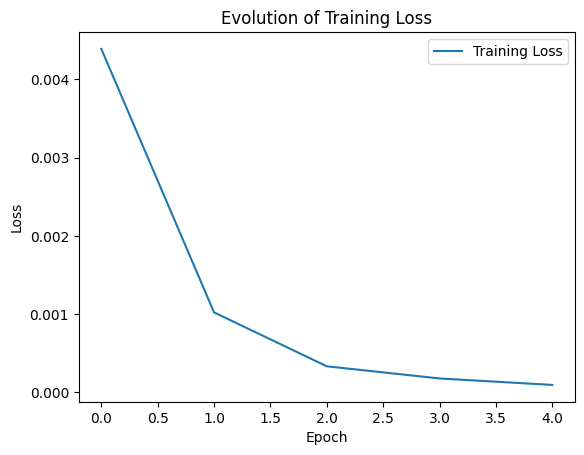

In [97]:
pretrained_model = pretrained_model.to(device)  # ✅ move everything to GPU
train_losses = []  # To store the losses for plotting
best_val_loss = float('inf')  # Initialize with a very large value


for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Train the model on the training set
    pretrained_model.train()

    # Initialize the training loss accumulator to zero
    training_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        #labels = labels.float()


        # Clear the gradients of all optimized parameters
        optimizer.zero_grad()

        # Forward pass: obtain model predictions for the input data
        outputs = pretrained_model(images)
        #print(outputs.shape)
        #print(labels.shape)


        # Compute the loss between the model predictions and the true labels
        loss = criterion(outputs, labels)

        # Backward pass: compute gradients of the loss with respect to model parameters
        loss.backward()

        # Update model parameters using the computed gradients and the optimizer
        optimizer.step()

        # Update the training loss
        training_loss += loss.item()

    # Calculate average training loss
    train_loss = training_loss / len(x_train)
    train_losses.append(train_loss)

    # Evaluate the model on the validation set
    pretrained_model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device) 
            
            # labels = labels.float()
            outputs = pretrained_model(images)

            # Compute the loss between the model predictions and the true labels
            loss = criterion(outputs, labels)

            # Update the validation loss
            val_loss += loss.item()

            # Round up and down to either 1 or 0\
            pred_probs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(pred_probs, dim=1)
            total_samples += labels.size(0)
            # Calculate how many images were correctly classified
            correct_preds += (predicted == labels).sum().item()

    # Calculate validation loss
    val_loss /= len(y_test)

    # Calculate validation accuracy
    val_acc = correct_preds / total_samples * 100

    # Print validation loss and accuracy
    print(f"Epoch [{epoch + 1}/{epochs}] Train Loss: {train_loss:.4f}  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Save the model if it performs better on validation set
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        #torch.save(pretrained_model.state_dict(), f'model/train/best_model_epoch_{epoch + 1}.pth')

print('Finished Training')

# Plotting the evolution of loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Training Loss')
plt.legend()
plt.show()

Using device: cuda


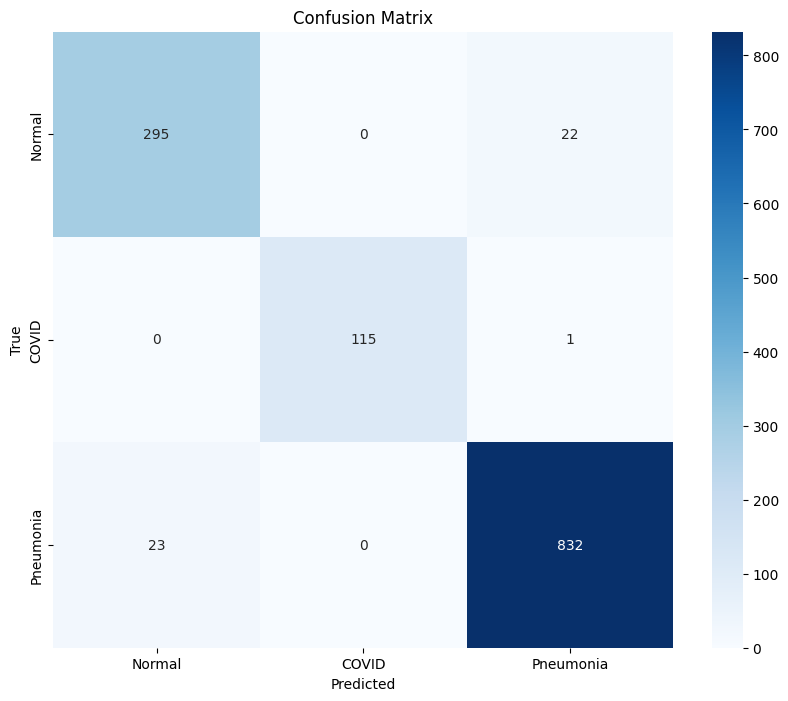


Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.93      0.93       317
       COVID       1.00      0.99      1.00       116
   Pneumonia       0.97      0.97      0.97       855

    accuracy                           0.96      1288
   macro avg       0.97      0.97      0.97      1288
weighted avg       0.96      0.96      0.96      1288


Per-class Accuracy:
Normal: 93.06%
COVID: 99.14%
Pneumonia: 97.31%

Overall Accuracy: 96.43%


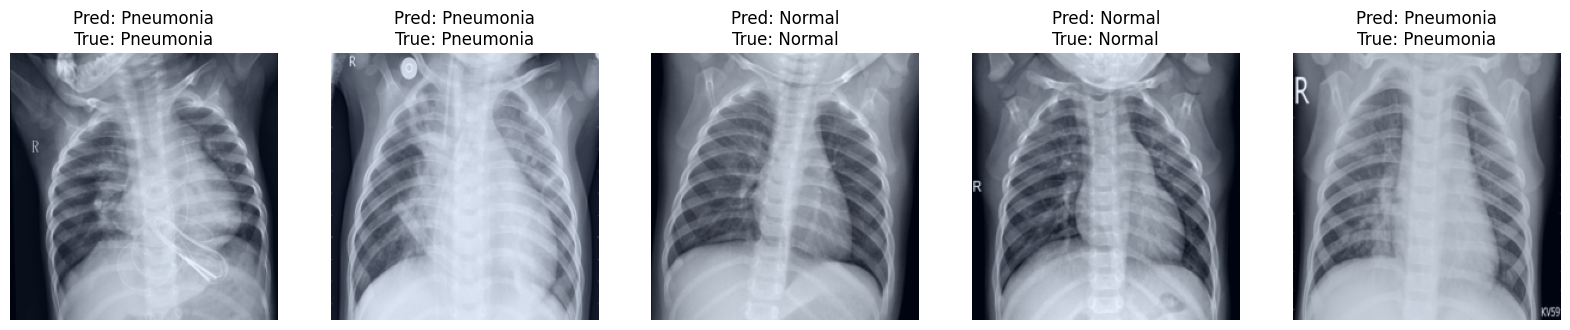

In [98]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['Normal', 'COVID', 'Pneumonia']
print(f"Using device: {device}")

# Move model to device
pretrained_model = pretrained_model.to(device)

def evaluate_model(model, test_loader, device):
    """
    Comprehensive model evaluation function
    """
    model.eval()
    all_preds = []
    all_labels = []
    class_names = ['Normal', 'COVID', 'Pneumonia']
    
    # Get predictions
    with torch.no_grad():
        batch_size = 64
        for images, labels in test_loader:

            images = images.to(device)
            labels = labels.to(device)
            # batch_x = x_test[i:i+batch_size]
            # batch_y = y_test[i:i+batch_size]

            # if len(batch_x) != len(batch_y):
            #     continue  # skip problematic batch

            # images = torch.stack(batch_x).to(device)
            # labels = torch.tensor(batch_y).long().to(device)

            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    
    # 1. Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # 2. Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # # 3. ROC Curves
    # plt.figure(figsize=(10, 8))
    # for i in range(3):
    #     fpr, tpr, _ = roc_curve(all_labels[:, i], all_preds[:, i])
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC Curves')
    # plt.legend()
    # plt.show()
    
    # 4. Per-class Accuracy
    print("\nPer-class Accuracy:")
    for i in range(3):
        class_mask = all_labels == i
        if class_mask.sum() == 0:
            print(f"{class_names[i]}: No samples in this class.")
            continue
        class_acc = np.mean(all_preds[class_mask] == i)
        print(f"{class_names[i]}: {class_acc*100:.2f}%")
        
    # 5. Overall Accuracy
    overall_acc = np.mean(all_preds == all_labels)
    print(f"\nOverall Accuracy: {overall_acc*100:.2f}%")
    
    return {
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels,
        'overall_accuracy': overall_acc
    }

# Visualize some predictions
def visualize_predictions(model, dataset, num_images=5):
    model.eval()
    plt.figure(figsize=(20, 4))
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    with torch.no_grad():
        for idx, i in enumerate(indices):
            img, true_label = dataset[i]
            output = model(img.unsqueeze(0).to(device))
            pred_label = torch.argmax(output).item()

            # Convert image for display
            img_np = img.permute(1, 2, 0).cpu().numpy()
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

            plt.subplot(1, num_images, idx + 1)
            plt.imshow(img_np)
            plt.title(f'Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}')
            plt.axis('off')
    plt.show()


# Run evaluation
# Modified evaluation call
results = evaluate_model(pretrained_model, test_loader, device)
visualize_predictions(pretrained_model, test_dataset)

# Save evaluation results
torch.save({
    'model_state_dict': pretrained_model.state_dict(),
    'evaluation_results': results,
}, 'model_evaluation_results.pth')